In [131]:
# This should be included at the top of every .ipynb file in the project
%load_ext autoreload
%autoreload 2

import sys
from pathlib import Path

PROJECT_ROOT = Path().resolve().parents[1]
sys.path.append(str(PROJECT_ROOT))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [132]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix , accuracy_score
import pandas as pd
import numpy as np

In [133]:
df = pd.read_csv("../../data/KDDTrain+.csv")
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,attack_class
0,0,udp,other,SF,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.0,0.00,normal,Normal
1,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.0,0.00,neptune,DoS
2,0,tcp,http,SF,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.0,0.01,normal,Normal
3,0,tcp,http,SF,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30,32,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,normal,Normal
4,0,tcp,private,REJ,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,121,19,0.0,0.0,1.0,1.0,0.16,0.06,0.00,255,19,0.07,0.07,0.00,0.00,0.00,0.00,1.0,1.00,neptune,DoS


In [134]:
df.drop(columns=["attack"] , inplace=True)

In [135]:
from sklearn.preprocessing import RobustScaler, FunctionTransformer
from sklearn.preprocessing import LabelEncoder , TargetEncoder

In [136]:
le = LabelEncoder()

In [137]:
df["attack_class"] = le.fit_transform(df["attack_class"])

In [138]:
categorical_cols = df.select_dtypes(include=["object", "category"]).columns
print(categorical_cols)


Index(['protocol_type', 'service', 'flag'], dtype='object')


In [140]:
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack_class
0,0,udp,other,SF,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.0,0.00,1
1,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.0,0.00,0
2,0,tcp,http,SF,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.0,0.01,1
3,0,tcp,http,SF,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30,32,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,1
4,0,tcp,private,REJ,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,121,19,0.0,0.0,1.0,1.0,0.16,0.06,0.00,255,19,0.07,0.07,0.00,0.00,0.00,0.00,1.0,1.00,0


In [141]:
X_train = df.drop(columns=["attack_class"])
y_train = df["attack_class"]
X_train = X_train.drop(columns=["num_outbound_cmds"])

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

log_features = ["duration", "src_bytes", "dst_bytes"]
scale_features = [
    "count", "srv_count",
    "dst_host_count", "dst_host_srv_count"
]

binary_features = [
    "land", "logged_in", "root_shell",
    "is_host_login", "is_guest_login"
]

rate_features = [col for col in df.columns if col.endswith("_rate")]

preprocessor = ColumnTransformer([
    ("log_scale", Pipeline([
        ("log", FunctionTransformer(np.log1p)),
        ("scale", RobustScaler())
    ]), log_features),

    ("scale", RobustScaler(), scale_features),

    ("rate", RobustScaler(), rate_features),

    ("bin", "passthrough", binary_features),

    ("cat", TargetEncoder(), ["service", "flag", "protocol_type"])
])

In [154]:
pipeline = Pipeline([
    ("prep", preprocessor),
    ("clf", RandomForestClassifier(
        n_jobs= -1,
        random_state= 42
    ))
])

In [155]:
from skopt.space import Integer, Categorical, Real

search_space = {
    "clf__n_estimators": Integer(200, 300),
    "clf__max_depth": Integer(10, 15),
    "clf__min_samples_split": Integer(2, 20),
    "clf__min_samples_leaf": Integer(1, 10),
    "clf__max_features": Categorical(["sqrt", "log2", None]),
    "clf__bootstrap": Categorical([True, False]),
}


In [156]:
from skopt import BayesSearchCV


In [ ]:
opt = BayesSearchCV(
    estimator=pipeline,
    search_spaces=search_space,
    n_iter=15,               
    cv=3,
    scoring="f1_macro",      
    n_jobs=-1,
    random_state=42,
    verbose=1
)


In [158]:
opt.fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


,estimator,Pipeline(step...m_state=42))])
,search_spaces,"{'clf__bootstrap': Categorical(c...), prior=None), 'clf__max_depth': Integer(low=1...m='normalize'), 'clf__max_features': Categorical(c...), prior=None), 'clf__min_samples_leaf': Integer(low=1...m='normalize'), ...}"
,optimizer_kwargs,None
,n_iter,15
,scoring,'f1_macro'
,fit_params,None
,n_jobs,-1
,n_points,1
,iid,'deprecated'
,refit,True
,cv,3


In [160]:
best_model = opt.best_estimator_

In [161]:
import joblib

# Save the full pipeline (preprocessing + model)
joblib.dump(best_model, "../../models/RF_MODEL.joblib")


['../../models/RF_MODEL.joblib']

In [162]:
test = pd.read_csv("../../data/KDDTest+.csv")

In [163]:
test["attack_class"] = le.transform(test["attack_class"])

In [165]:
X_test = test.drop(columns=["attack_class" , "attack"])
y_test = test["attack_class"]
X_test = X_test.drop(columns=["num_outbound_cmds"])

In [166]:
y_pred = best_model.predict(X_test)

In [167]:
acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {acc:.4f}")

Test Accuracy: 0.7694


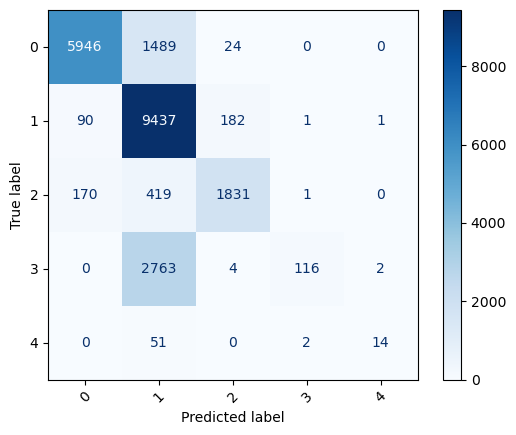

In [168]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred, labels=best_model.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot(cmap="Blues", xticks_rotation=45)

In [169]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.96      0.80      0.87      7459
           1       0.67      0.97      0.79      9711
           2       0.90      0.76      0.82      2421
           3       0.97      0.04      0.08      2885
           4       0.82      0.21      0.33        67

    accuracy                           0.77     22543
   macro avg       0.86      0.55      0.58     22543
weighted avg       0.83      0.77      0.73     22543

